In [1]:
import numpy as np
import re
import scipy.stats       as stats
import scipy.optimize    as optimize
import matplotlib.pyplot as plt

%matplotlib inline

Before we proceed with the problem, let's first read in our data file. using the provided parsing code.

In [2]:
datafile = 'w10-data.tbl'

with open(datafile) as f:
    # First header line gives us the time points
    fields = f.readline().split()
    # timepoints (as integers) 
    timepoints = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        timepoints.append(int(match.group(1)))
    timepoints = np.array(timepoints)
    # number of timepoints
    N = len(timepoints)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()

    # sigmas, or our known values 
    sigmas = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        sigmas[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = [] # gene names
    data = [] # array of recorded RNA expression levels for each time point and for each gene
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        data.append( np.array( [ float(s) for s in fields[1:]] ))

    # number of genes
    G = len(data)

## 1. Solve by maximum likelihood.

Given the RNA-seq data, use maximum likelihood to solve for the unknown phases $\phi$.

Below, we first define a function <code>y_pred</code> in order to make predictions given a set of parameters and timepoints. It returns a 1D array of predictions with length eight, since there are eight timepoints to make predictions of RNA expression levels (TPM) for. This function will later be called on for every gene in a for loop.

This function follows our defined linear regression function: 
$$y_t = p_0 + p_1 sin(2\pi \omega t) + p_2 cos(2\pi \omega t)$$ 

As given, the three parameters are: 
$$p_0 = b$$
$$p_1 = a cos(2 \pi \omega \phi)$$
$$p_2 = a sin(2 \pi \omega \phi)$$

where $\phi = \frac{1}{24}$.

In [3]:
def y_pred(a, b, phi, timepoints):
    # circadian frequency is known
    omega = 1/24
    
    # predicted observations using our linear regression function / modeling equation for y_t 
    y_preds = [b + 
               a*np.cos(2*np.pi*omega*phi)*np.sin(2*np.pi*omega*t) +
               a*np.sin(2*np.pi*omega*phi)*np.cos(2*np.pi*omega*t) 
               # iterate through each time point
               for t in timepoints]

    return y_preds

For each gene independently, we calculate a log likelihood $log$  P(data $\mid \theta)$ using the <code>stats.norm.pdf</code> function.

In [4]:
# calculate negative loglikelihood for a certain set of parameters over 8 timepoints
# data is a 1D array of eight ACTUAL recorded data values
def nll(theta, sigmas, data, timepoints):
    """
    Function to minimize the negative log likelihood function.
    ---------
    Input:
    - data: an array of all of the RNA seq data
    - theta: b, a, and phi are the unknown parameters for each timepoint/experiment
    - sigmas: 1D array of known standard deviation values for each timepoint/experiment
    - timepoints: the eight timepoints
    """

    # define our set of parameters based on the input theta
    a, b, phi = theta

    # calculate predictions for a single gene
    y_preds = y_pred(a, b, phi, timepoints)

    # calculate residuals by subtracting our predictions (calculated above) from the observed data 
    residuals = [observed - predicted for observed, predicted in zip(data, y_preds)]
    
    # below, we use spicy stats to calculate the negative log likelihood utilizing the residuals and known standard deviations
    nll = -np.sum([stats.norm.logpdf(residual, 0 , sigma) for residual, sigma in zip(residuals, sigmas)])

    # return negative log likelihood
    return nll

Below, we actually run the minimizer our negative log likelihood function in order to solve for the optimal parameters $a$, $b$, and $\phi$ for each gene's log likelihood function. <code>optimize.minimize</code> takes in the <code>nll</code> function that we wrote above, a random initial guess for the three unknown parameters as defined as <code>initial_guess = [1.0, 0.0, 0.0]</code>, the row of observed data for the current gene, the list of known sigma values (standard deviations), and the list of timepoints.

In [5]:
# import pandas to output a dataframe of the optimal parameters for the harmonic regression equation for every gene
import pandas as pd

# initial guesses for a, b, and phi
initial_guess = [1.0, 0.0, 0.0]

# initialize a list to store the results in 
results = []

# iterate through each of the 12 genes (G: number of genes)
for i in range(G):
    # select the row in the data array that corresponds to the gene we are looking at 
    # current_data = 1D numpy array of 8 values; the data vector for the current gene
    current_data = data[i]
    
    # timepoints and sigmas stay the same for every row of gene expression
    # use optimize.minimize() to minimize the negative log likelihood and then give us the best parameter values 
    result = optimize.minimize(nll, initial_guess, args=(sigmas, current_data, timepoints))
    optimal_params = result.x

    # append results as a dictionary
    results.append({
        'gene' : genenames[i],
        'a': optimal_params[0],
        'b': optimal_params[1],
        'phi': optimal_params[2]
    })

# convert dictionary to DataFrame
results_df = pd.DataFrame(results)

We also need to adjust our phases manually for the $\phi$ values that outputted as negative. 
Since phase is periodic, we want to bring these negative values of $\phi$ between the range of 0 and 24; thus, we add 24 to the negative $\phi$ values and subtract 24 from $\phi$ values greater than 30. 

When we have negative $a$ values, we also need to add half a period to our $\phi$ and flip the sign of the $a$.

Flipping $a$ to be positive standardizes the positive representation of the waveform. Then, half a period (12) to our $\phi$ ensures the waveform correctly represents the same oscillation with the positive amplitude.

Below is a table (<code>results_df</code>) of the results of my solution, with the gene name in the leftmost column and the corresponding parameters in the right columns.

In [6]:
# update 'phi' values if they are less than 0
results_df.loc[results_df['phi'] < 0, 'phi'] += 24
results_df.loc[results_df['phi'] > 30, 'phi'] -= 24

# update 'a' values if they are negative and adjust 'phi' accordingly
for idx, row in results_df.iterrows():
    if row['a'] < 0:
        # add 12 to 'phi' and make 'a' positive
        results_df.at[idx, 'phi'] += 12
        results_df.at[idx, 'a'] = -row['a']

In [7]:
results_df

,gene,a,b,phi
0,wkiN,19.046044,47.594866,19.799483
1,wicQ,20.866588,37.638897,16.621219
2,zgvC,25.105966,45.002678,12.137690
3,dczC,27.253388,49.376144,3.875152
4,jarO,22.926435,43.676182,0.130764
5,lfpY,22.856187,40.862160,9.606090
6,retS,25.248077,49.042287,8.210380
7,cbaJ,21.942914,47.496120,1.924066
8,vdbK,17.548340,45.386737,6.193824
9,slwZ,26.453584,45.422724,22.386540


## 2. Compare solutions
Moriarty is incensed that you have a different solution. He offers to bet you on who's right. Compute the total log likelihood (summed over all 12 genes) for Moriarty's solution and yours. Which is more likely, and by how much? If Moriarty offers you even odds on his bet, should you take it?

Below, we first grab Moriarty's predictions using his script. We will then call on the list of parameters to compute the total log likelihood.

In [8]:
import re
import sys

# Ooh look! Parsing for `w10-data.tbl`. 
# This leaves us with
#    N         : number of experiments (columns in the table)
#    G         : number of genes (rows in the table)
#    X[i]      : array of time points, in hrs, for the N experiments
#    S_true[i] : array of sigmas for the experiments
#    Y[i][t]   : GxN: observed tpm for gene i, time point t
#   
datafile = 'w10-data.tbl'
with open(datafile) as f:
    # First header line gives us the time points
    fields = f.readline().split()
    X = []
    for s in fields:
        match = re.search(r'^(\d+)hr', s)
        X.append(int(match.group(1)))
    X = np.array(X)
    N = len(X)

    # Second header line gives us "gene" followed by +=SD's
    fields = f.readline().split()
    S_true = np.zeros(N)
    for i,s in enumerate(fields[1:]):
        match = re.search(r'^\+-(\d+)', s)
        S_true[i] = float(match.group(1))

    # Third header line is just ------ stuff
    f.readline()

    # Remaining lines are data
    genenames = []
    Y = []
    for line in f.readlines():
        fields = line.split()
        genenames.append(fields[0])
        Y.append( np.array( [ float(s) for s in fields[1:]] ))
    G = len(Y)


# Moriarty's method: ordinary least squares on:
#    y_t = b + (a cos p) sin t + (a sin p) cos t
#
b_fit = np.zeros(G)
a_fit = np.zeros(G)
p_fit = np.zeros(G)

b_opt = np.zeros(G)
a_opt = np.zeros(G)
p_opt = np.zeros(G)

for g in range(G):
    # We have to set up a matrix A the way numpy.linalg.lstsq() wants it.
    #
    A = np.zeros((N, 3))  # observations x coefficients
    for i in range(N):
        A[i][0] = 1.
        A[i][1] = np.sin(2. * np.pi * X[i] / 24)  
        A[i][2] = np.cos(2. * np.pi * X[i] / 24)

    try:
        result    = np.linalg.lstsq(A, Y[g], rcond=-1)[0]
    except:
        sys.exit("Linear least square fit failed")

    p_fit[g]  = np.arctan(result[2] / result[1])   # in radians at first
    b_fit[g]  = result[0]
    a_fit[g]  = result[1] / np.cos(p_fit[g])

    p_fit[g] = 24 * p_fit[g] / (2 * np.pi)       # now in hours
    if a_fit[g] < 0:                             # there's a symmetry in the solution we have to deal with.
        a_fit[g]  = -a_fit[g]
        p_fit[g] += 12
    while p_fit[g] < 0:  p_fit[g] += 24
    while p_fit[g] > 24: p_fit[g] -= 24

I then edited my <code>nll</code> to instead calculate log likelihood for a list of parameters (such that we can call it on our predictions and also Moriarty's predictions).

In [9]:
# calculate log likelihood for a given set of parameters over 8 timepoints
# data is a 1D array of eight ACTUAL recorded data values
def log_likelihood(a, b, phi, sigmas, data, timepoints):
    """
    Function to calculate the log likelihood of our solution.
    ---------
    Input:
    - data: an array of all of the RNA seq data
    - theta: b, a, and phi are now known -- they are parameters for each timepoint/experiment
    - sigmas: 1D array of known standard deviation values for each timepoint/experiment
    - timepoints: the eight timepoints
    """

    # calculate predictions for a single gene
    y_preds = y_pred(a, b, phi, timepoints)

    # calculate residuals by subtracting our predictions (calculated above) from the observed data 
    residuals = [observed - predicted for observed, predicted in zip(data, y_preds)]
    
    # below, we use spicy stats to calculate the negative log likelihood utilizing the residuals and known standard deviations
    log_likelihood = np.sum([stats.norm.logpdf(residual, 0 , sigma) for residual, sigma in zip(residuals, sigmas)])

    # return log likelihood
    return log_likelihood

Below, I call on the <code>log_likelihood</code> function to calculate the total log likelihood for my predictions, summed over all 12 genes.

In [10]:
# iterate through every gene
my_ll = 0
for i in range(G):
    # arguments: a, b, phi, sigmas, data, timepoints
    # set up the parameters a, b, and phi
    a = results_df['a'][i]
    b = results_df['b'][i]
    phi = results_df['phi'][i]

    current_data=data[i]

    my_ll += log_likelihood(a, b, phi, sigmas, current_data, timepoints)

# could look at the genes that are behaving differently between mine and moriarty's
# see why his model is failing
# his assumption is that the variance is the same for every single data point -> incorrect assumption
# what is the diff between normal LS and weighted LS (after yoiu take into account the different variances for each data point) 

I do this again but to calculate the total log likelihood for Moriarty's predictions, summed over all 12 genes.

In [11]:
# iterate through every gene
moriarty_ll = 0
for i in range(G):
    # arguments: a, b, phi, sigmas, data, timepoints
    # set up the parameters a, b, and phi
    a = a_fit[i]
    b = b_fit[i]
    phi = p_fit[i]

    current_data=data[i]

    moriarty_ll += log_likelihood(a, b, phi, sigmas, current_data, timepoints)

**Total log likelihoods:** The two total log likelihoods are printed below.

In [16]:
print(f"The total log likelihood for my solution is {round(my_ll, 4)}"
     f" and for Moriarty's solution is {round(moriarty_ll, 4)}.")

print(f"Our maximum likelihood fit parameters are {np.exp(my_ll) / np.exp(moriarty_ll)} times as likely as Moriarty's harmonic regression parameters.")

The total log likelihood for my solution is -311.835 and for Moriarty's solution is -519.4262.
Our maximum likelihood fit parameters are 1.4312530457447304e+90 times as likely as Moriarty's harmonic regression parameters.


**Question:** Which is more likely, and by how much? If Moriarty offers you even odds on his bet, should you take it?

As printed above, the total log likelihood for my solution is -311.835 and for Moriarty's solution is -519.4262. Our maximum likelihood fit parameters are 1.4312530457447304e+90 times as likely as Moriarty's harmonic regression parameters.

The phases for Moriarty's least-squares solution are not regularly spaced between 0 and 24.

If we look at our $\phi$ values, we see that they are centered around 0, around 2, around 4, around 8. This indicates that our method will be better at finding the genes that are turning on every 2 hours, or that peak in expression level (as is occuring in the actual genes/data).

I would take Moriarty's offer for even odds on his bet because our maximum likelihood model predicts significantly better than Moriarty's model. My total log likelihood is less negative than Moriarty's. 

## 3. Plot the fits
For each of the 12 genes, plot the observed data and the two fits (so you can show Moriarty how he went wrong, after taking his money from the bet).

First, let's grab the predictions that are produced using Moriarty's OLS method. We do this by taking in the parameters that we calculated in part 2 (<code>a_fit</code>, <code>b_fit</code>, and <code>p_fit</code>).

In [48]:
# initialize a list to store our data predictions for each gene
gene_predictions = []

# iterate through each gene
for i in range(G):
    # placeholder for storing predictions for this gene
    timepoint_predictions = []
    
    # iterate through each timepoint
    for t in timepoints:
        # calculate the predicted value using the given formula
        y_t = b_fit[i] + (a_fit[i] * np.cos(p_fit[i])) * np.sin(t) + (a_fit[i] * np.sin(p_fit[i])) * np.cos(t)
        timepoint_predictions.append(y_t)
    # append predictions for this gene as a row in the results
    gene_predictions.append(timepoint_predictions)

Below, we plot the observed data and the two fits. 

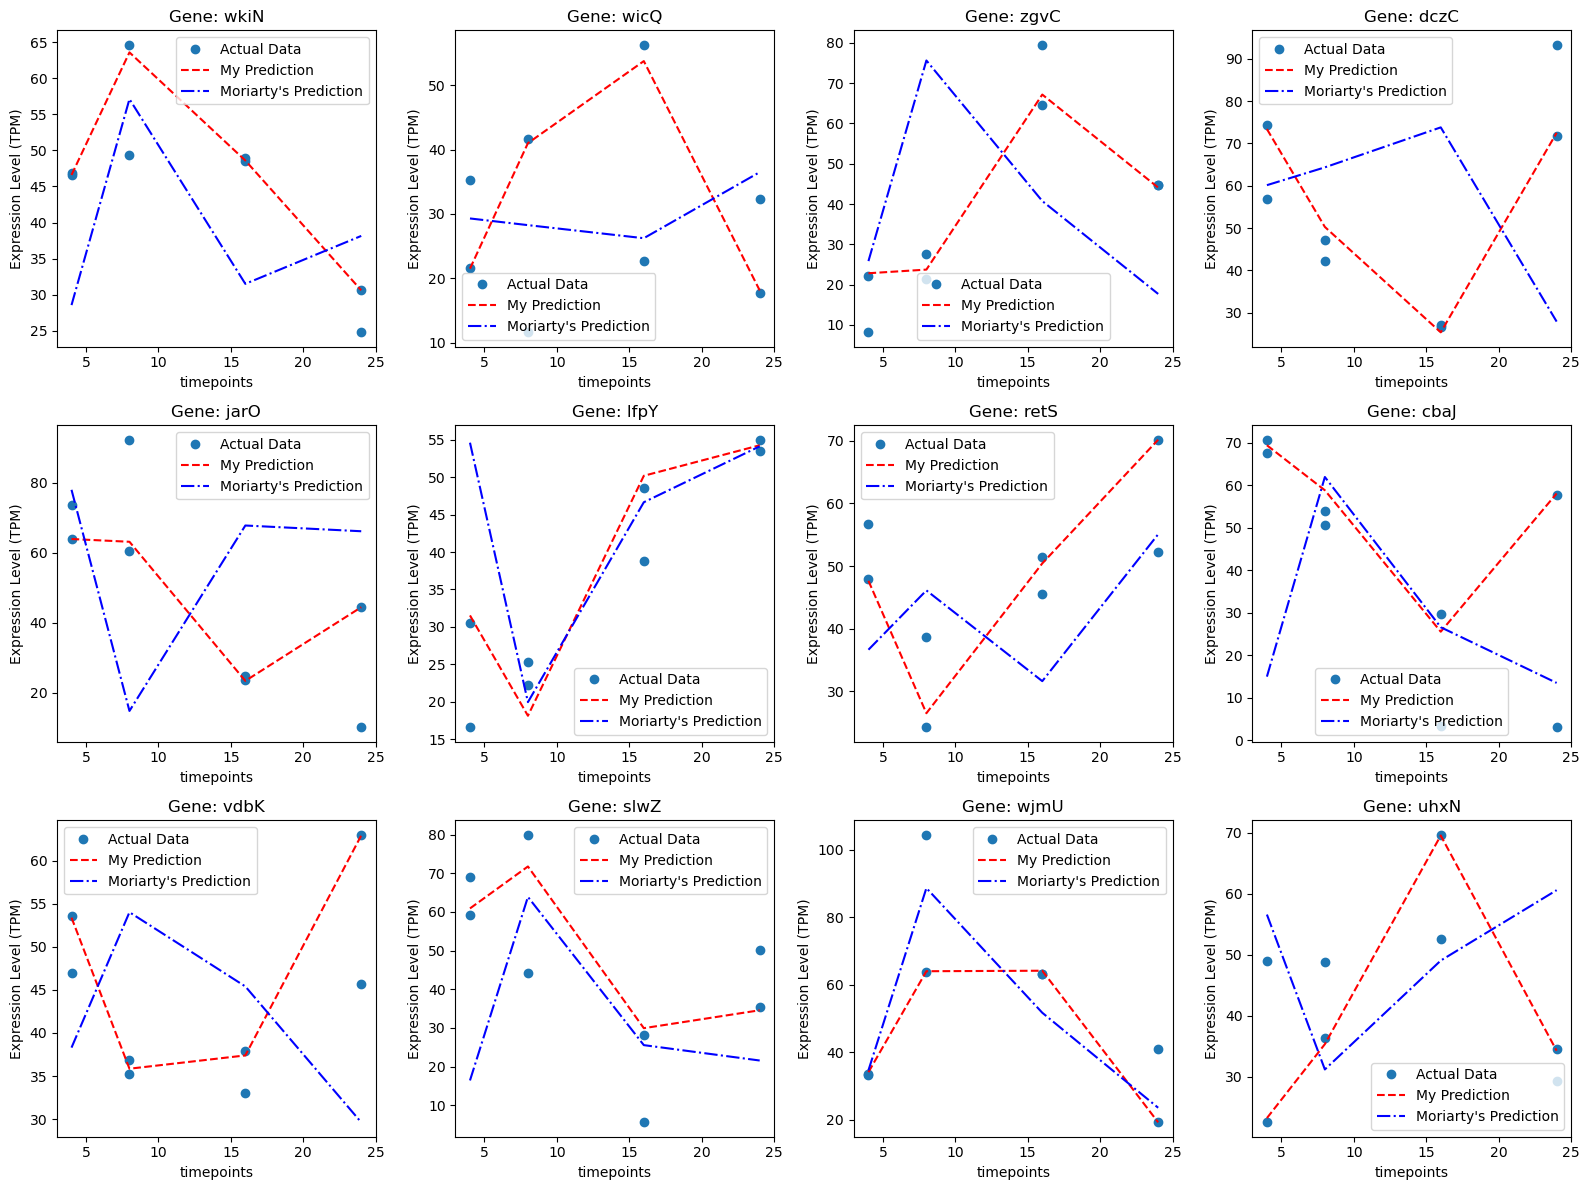

In [54]:
# use a 3x4 multiplanel figure 
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()  

# iterate through all 12 genes 
for i, ax in enumerate(axes):    
    # do more timepoints -> perhaps do np.linspace between the entire range
    fitted_preds = y_pred(results_df['a'][i], results_df['b'][i], results_df['phi'][i], timepoints)
    
    # plot the observed data and the two fits
    
    # plot the observed data 
    # set up the current data row
    current_data = data[i]
    ax.plot(timepoints, current_data, 'o', label="Actual Data")
    
    # plot my prediction as a red dashed line
    ax.plot(timepoints, fitted_preds, 'r--', label="My Prediction")
    
    # plot Moriarty's prediction as a blue dotted line
    ax.plot(timepoints, gene_predictions[i], 'b-.', label="Moriarty's Prediction")
    ax.set(xlabel = "timepoints", ylabel = "Expression Level (TPM)", title = f"Gene: {genenames[i]}")
    ax.legend()

plt.tight_layout()
plt.show()

From the graphs above, we can see that my solution fits the observed data better than Moriarty's solution. 

In addition to plotting just the eight predictions using the parameter values of my solution, I also tried plotting predictions for timepoints spanning the range from 0 to 25.

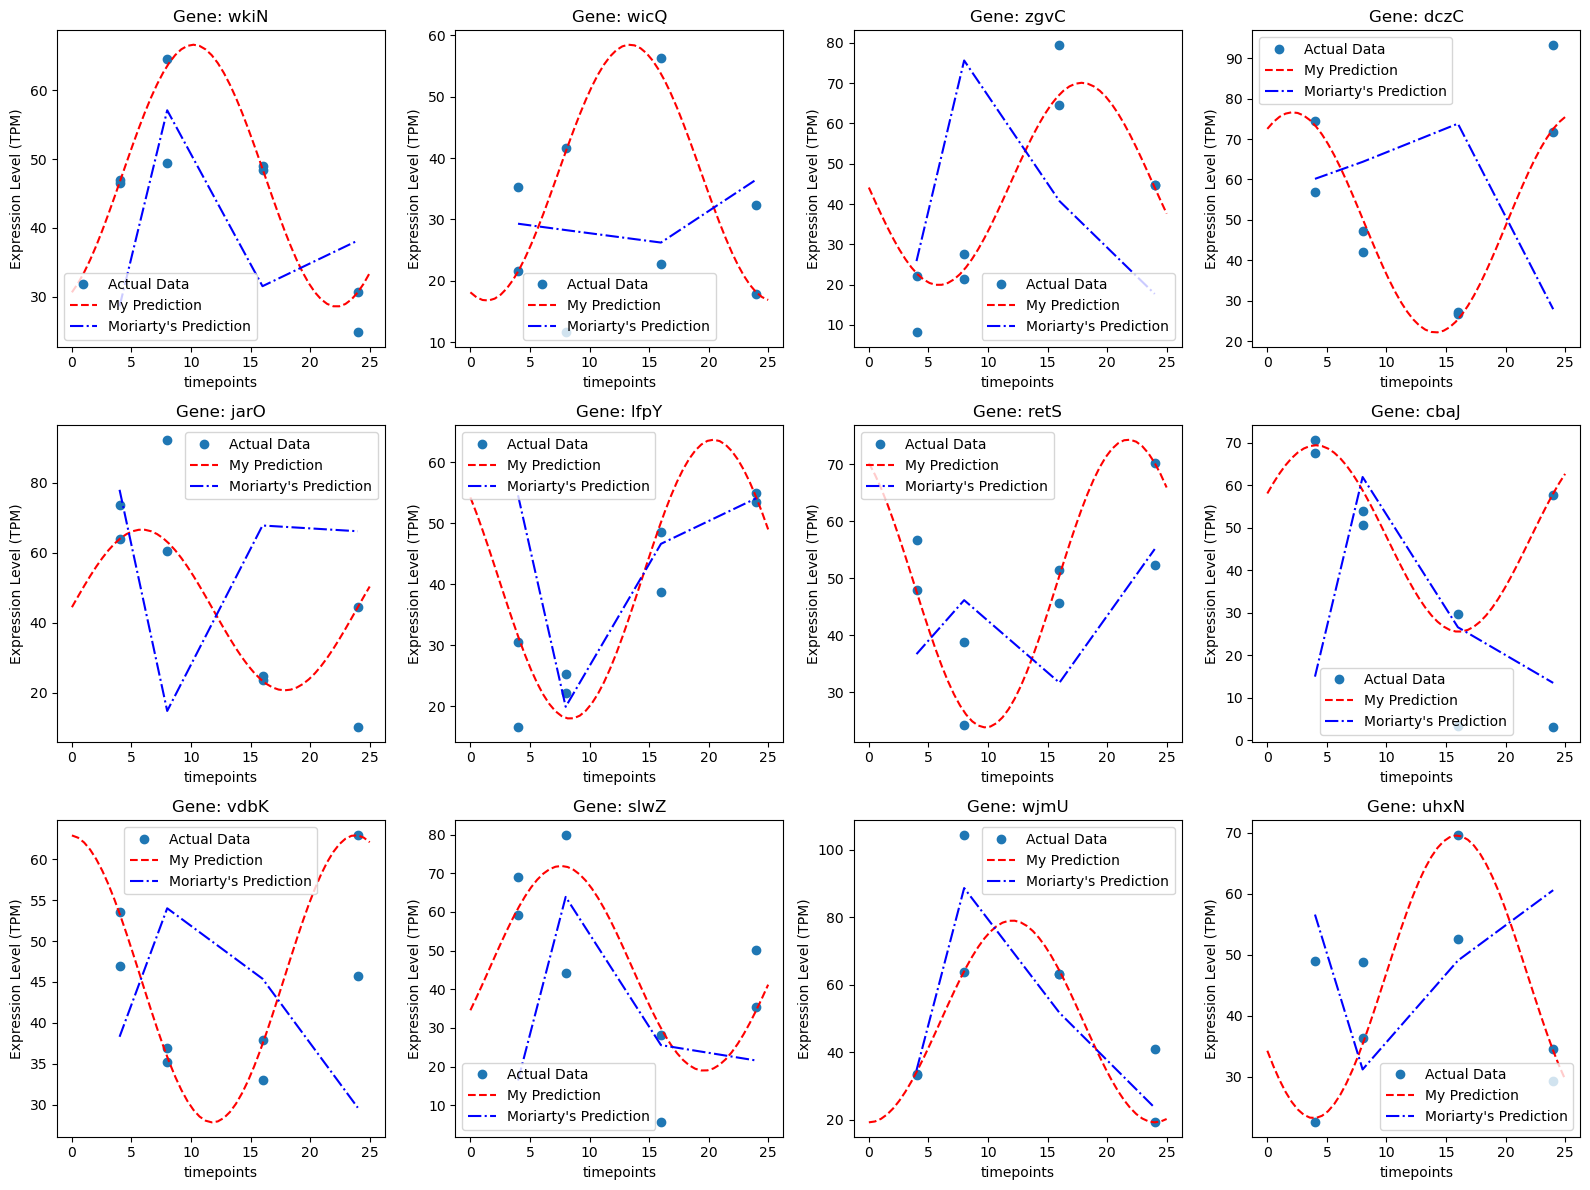

In [55]:
# use a 3x4 multiplanel figure 
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.flatten()  

# iterate through all 12 genes 
for i, ax in enumerate(axes):    
    more_timepoints = np.linspace(0, 25)
    # use np.linspace to create more timepoints
    fitted_preds = y_pred(results_df['a'][i], results_df['b'][i], results_df['phi'][i], more_timepoints)
    
    # plot the observed data and the two fits
    
    # plot the observed data 
    # set up the current data row
    current_data = data[i]
    ax.plot(timepoints, current_data, 'o', label="Actual Data")
    
    # plot my prediction as a red dashed line
    ax.plot(more_timepoints, fitted_preds, 'r--', label="My Prediction")
    
    # plot Moriarty's prediction as a blue dotted line
    ax.plot(timepoints, gene_predictions[i], 'b-.', label="Moriarty's Prediction")
    ax.set(xlabel = "timepoints", ylabel = "Expression Level (TPM)", title = f"Gene: {genenames[i]}")
    ax.legend()

plt.tight_layout()
plt.show()

**Conclusion:** From both sets of plots, we can see that our prediction in red more closely follows the patterns of the actual data, showing that my solution is better than Moriarty's. More specifically, it appears that my model fit line is closer to the data points with lower variance, while Moriarty's model seems to be highly influenced by points with high variance (points that are farther apart on the y-axis).

My solution utilizes the known sigmas, or the standard deviations associated with each timepoint, accounting for low confidence in some datapoints.

In [46]:
%load_ext watermark
%watermark -v -m -p jupyter,numpy,matplotlib

Python implementation: CPython
Python version       : 3.12.5
IPython version      : 8.27.0

jupyter   : 1.1.1
numpy     : 2.1.1
matplotlib: 3.9.2

Compiler    : Clang 16.0.6 
OS          : Darwin
Release     : 21.6.0
Machine     : x86_64
Processor   : i386
CPU cores   : 4
Architecture: 64bit

